In [25]:
%matplotlib inline

In [26]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

np.random.seed(1234)

In [27]:
from math import sin, cos, pi

def rot(ev, theta):
    R = np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])
    return np.dot(np.dot(R, np.diag(ev)), R.T)

Fisher's determinant
---

Here we use Fisher's determinant to separate two Gaussian clusters of data.

In [28]:
sigma1 = rot([0.5, 0.1], pi/4)
sigma2 = rot([0.6, 0.2], pi/2)
mu1 = np.array([1.0, 0.0])
mu2 = np.array([-1.0, 1.0])

In [29]:
samples1 = np.random.multivariate_normal(mu1, sigma1, 100)
samples2 = np.random.multivariate_normal(mu2, sigma2, 100)

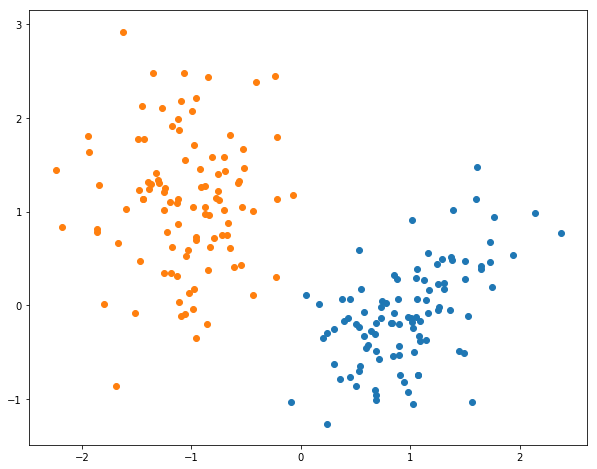

In [30]:
plt.scatter(*samples1.T)
plt.scatter(*samples2.T)

In [31]:
xs = np.linspace(-2, 2, 100)
ys = np.linspace(-2, 3, 100)
X, Y = np.meshgrid(xs, ys)
XY = np.stack([X, Y], axis=-1)

In [32]:
d1 = XY - mu1
d2 = XY - mu2
prec1 = np.linalg.pinv(sigma1)
prec2 = np.linalg.pinv(sigma2)
f = np.log(np.linalg.det(sigma2)/np.linalg.det(sigma1))

fisher = (
    0.5 * np.einsum("ijk, kl, ijl -> ij", d1, prec1, d1) - 
    0.5 * np.einsum("ijk, kl, ijl -> ij", d2, prec2, d2) + f
)

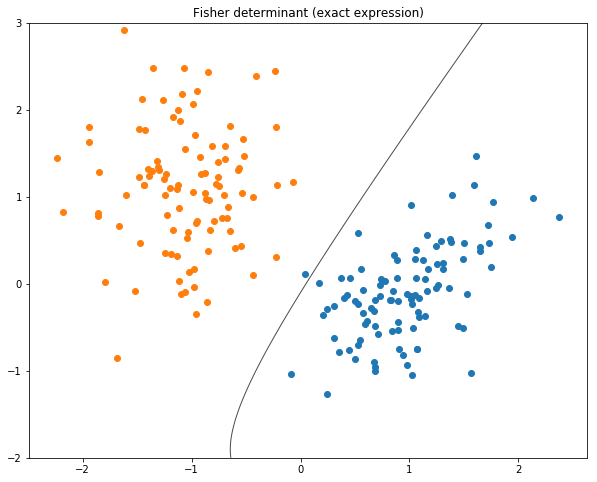

In [33]:
plt.contour(X, Y, fisher, [0], colors='k', linewidths=1, alpha=0.7)

plt.scatter(*samples1.T)
plt.scatter(*samples2.T)
plt.title("Fisher determinant (exact expression)");

In [34]:
sigma = (sigma1 + sigma2) / 2
prec = np.linalg.pinv(sigma)

fisher_linear = (
    np.einsum("i,ij,klj", mu1 - mu2, prec, XY)
    - 0.5 * (np.dot(mu1, np.dot(prec, mu1)) - np.dot(mu2, np.dot(prec, mu2)))
)

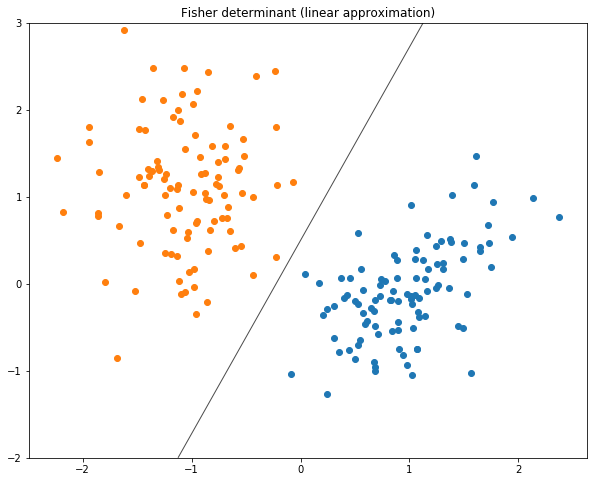

In [35]:
plt.contour(X, Y, fisher_linear, [0], colors='k', linewidths=1, alpha=0.7)

plt.scatter(*samples1.T)
plt.scatter(*samples2.T)

plt.title("Fisher determinant (linear approximation)");

Nonlinearly separable clusters, SVM
---

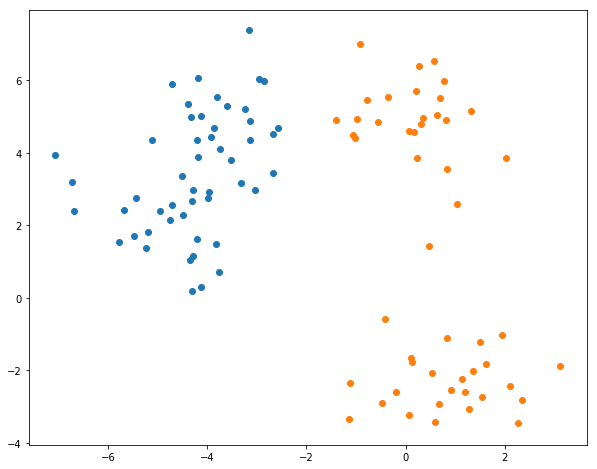

In [36]:
from sklearn.datasets import make_blobs

centers = np.array([
    [-4, 5],
    [0, 5],
    [-5, 2],
    [1, -2]
])
samples, labels = make_blobs(n_samples=100, n_features=2, centers=centers, random_state=1234)
labels %= 2

n = samples.shape[0]

plt.scatter(*samples[labels==0].T)
plt.scatter(*samples[labels==1].T)

xmin = samples[:, 0].min()
xmax = samples[:, 0].max()
ymin = samples[:, 1].min()
ymax = samples[:, 1].max()

In [37]:
from sklearn.metrics import pairwise_distances

def gaussian_kernel(X, Y, gamma=1.0):
    dists = pairwise_distances(X, Y)
    return np.exp(-dists**2/(2*gamma**2))
    

In [38]:
import cvxopt


def solve_dual_problem(samples, labels, kernel, support_cutoff=1e-5):
    signs = np.where(labels == 0, 1, -1)
    kernel_matrix = kernel(samples, samples)
    signed_kernel_matrix = kernel_matrix * np.outer(signs, signs)
    
    P = cvxopt.matrix(signed_kernel_matrix)
    q = cvxopt.matrix(-np.ones(n), tc='d')
    G = cvxopt.matrix(-np.eye(n), tc='d')
    h = cvxopt.matrix(np.zeros(n), tc='d')
    A = cvxopt.matrix(signs[np.newaxis, :], tc='d')
    b = cvxopt.matrix([0], tc='d')

    sol = cvxopt.solvers.qp(P, q, G, h, A, b)
    
    a = np.squeeze(np.array(sol['x']))
    is_support = a > support_cutoff
    
    n_support = is_support.sum()
    b = (signs - np.dot(kernel_matrix, signs * a))[is_support].sum() / n_support

    return a, b, is_support
    

a, b, is_support = solve_dual_problem(samples, labels, gaussian_kernel)

     pcost       dcost       gap    pres   dres
 0: -7.3580e+00 -2.2144e+01  2e+02  1e+01  1e+00
 1: -4.0156e+00 -2.0288e+01  2e+01  2e-15  4e-16
 2: -7.5729e+00 -1.0736e+01  3e+00  5e-16  4e-16
 3: -8.3940e+00 -8.9743e+00  6e-01  8e-16  3e-16
 4: -8.6187e+00 -8.7438e+00  1e-01  5e-16  3e-16
 5: -8.6695e+00 -8.7067e+00  4e-02  4e-16  3e-16
 6: -8.6888e+00 -8.6970e+00  8e-03  7e-16  3e-16
 7: -8.6936e+00 -8.6938e+00  2e-04  1e-15  3e-16
 8: -8.6937e+00 -8.6937e+00  2e-06  1e-15  3e-16
Optimal solution found.


In [49]:
a

array([  8.73647031e-01,   1.69025782e-07,   6.24377012e-08,
         2.00992868e-07,   3.45316392e-07,   5.34855355e-07,
         5.15196977e-01,   2.28092134e-01,   2.02678002e-07,
         9.99999996e+00,   5.09876493e-02,   9.99999995e+00,
         1.68410912e-01,   1.08257397e-06,   2.33635767e-01,
         8.38522198e-08,   2.00960456e-06,   2.24022833e+00,
         8.54030369e-07,   4.19232085e-07,   6.31464526e-07,
         4.31309128e-07,   4.70697928e-08,   3.75844821e-01,
         2.47494401e-07,   6.84709761e-07,   1.47653065e-06,
         6.75111090e-08,   4.62010895e-01,   1.03046072e-06,
         7.58285915e-02,   3.89410089e-01,   7.61473965e+00,
         5.02826550e-07,   6.89863256e-08,   9.04616050e-08,
         1.23859628e+00,   6.14602502e-07,   7.51010063e-06,
         4.49914476e-01,   1.77037641e-06,   5.99949212e-07,
         5.98143348e-08,   3.93809518e-01,   1.01146419e-06,
         9.99999986e+00,   3.54546097e-07,   6.62512569e-08,
         2.59064764e-07,

In [39]:
n_support = is_support.sum()
support_a = a[is_support]
support_vectors = samples[is_support]
support_labels = labels[is_support]

print("Number of support vectors: {} out of {}".format(n_support, len(a)))
print("b: {:.03f}".format(b))

Number of support vectors: 34 out of 100
b: -0.156


In [40]:
def decision_function(X, kernel, support_a, support_vectors, support_labels, b):
    signs = np.where(support_labels == 0, 1, -1)
    return np.dot(kernel(X, support_vectors), signs*support_a) + b

In [41]:
x = np.linspace(xmin, xmax)
y = np.linspace(ymin, ymax)
X, Y = np.meshgrid(x, y)
XY = np.stack([X, Y], axis=-1).reshape(-1, 2)

Z = decision_function(XY, gaussian_kernel, support_a, support_vectors, support_labels, b).reshape(50, 50)

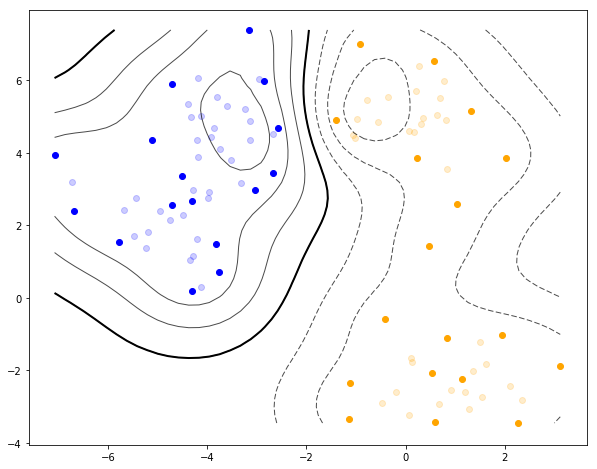

In [42]:
plt.scatter(*samples[(labels==0) & is_support].T, color='blue')
plt.scatter(*samples[(labels==1) & is_support].T, color='orange')
plt.scatter(*samples[(labels==0) & ~is_support].T, alpha=0.2, color='blue')
plt.scatter(*samples[(labels==1) & ~is_support].T, alpha=0.2, color='orange')

plt.contour(X, Y, Z, colors='k', linewidths=1, alpha=0.7)
plt.contour(X, Y, Z, [0], colors='k', linewidths=2, alpha=1.0)

Non-separable clusters
---

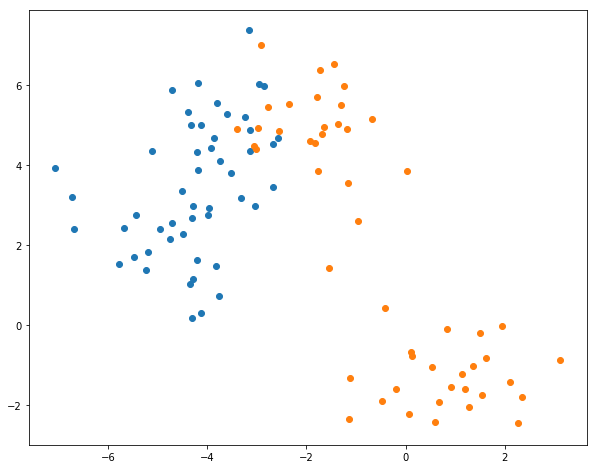

In [43]:
centers = np.array([
    [-4, 5],
    [-2, 5],
    [-5, 2],
    [1, -1]
])
samples, labels = make_blobs(n_samples=100, n_features=2, centers=centers, random_state=1234)
labels %= 2

n = samples.shape[0]

plt.scatter(*samples[labels==0].T)
plt.scatter(*samples[labels==1].T)

xmin = samples[:, 0].min()
xmax = samples[:, 0].max()
ymin = samples[:, 1].min()
ymax = samples[:, 1].max()

In [44]:
def solve_dual_problem(samples, labels, kernel, C, support_cutoff=1e-5):
    signs = np.where(labels == 0, 1, -1)
    kernel_matrix = kernel(samples, samples)
    signed_kernel_matrix = kernel_matrix * np.outer(signs, signs)
    
    P = cvxopt.matrix(signed_kernel_matrix)
    q = cvxopt.matrix(-np.ones(n), tc='d')
    G = cvxopt.matrix(np.vstack([-np.eye(n), np.eye(n)]), tc='d')
    h = cvxopt.matrix(n*[0] + n*[C], tc='d')
    A = cvxopt.matrix(signs[np.newaxis, :], tc='d')
    b = cvxopt.matrix([0], tc='d')

    sol = cvxopt.solvers.qp(P, q, G, h, A, b)
    
    a = np.squeeze(np.array(sol['x']))
    is_support = a > support_cutoff
    
    n_support = is_support.sum()
    b = (signs - np.dot(kernel_matrix, signs * a))[is_support].sum() / n_support

    return a, b, is_support

In [70]:
a, b, is_support = solve_dual_problem(samples, labels, gaussian_kernel, C=10000)

     pcost       dcost       gap    pres   dres
 0:  3.1623e+08 -1.7953e+09  2e+09  4e-12  2e-12
 1:  6.4435e+07 -1.6249e+08  2e+08  7e-12  3e-12
 2:  1.5570e+07 -2.9482e+07  5e+07  1e-11  1e-12
 3:  2.8901e+06 -7.5352e+06  1e+07  6e-12  1e-12
 4:  4.6904e+05 -1.1592e+06  2e+06  2e-16  1e-12
 5:  5.1330e+04 -2.2197e+05  3e+05  9e-13  1e-12
 6: -1.1672e+03 -1.1391e+05  1e+05  5e-12  8e-13
 7: -1.8060e+04 -9.1062e+04  7e+04  2e-16  1e-12
 8: -3.1071e+04 -5.3651e+04  2e+04  5e-12  1e-12
 9: -3.6568e+04 -4.0953e+04  4e+03  2e-16  1e-12
10: -3.7878e+04 -3.8431e+04  6e+02  2e-16  1e-12
11: -3.8054e+04 -3.8087e+04  3e+01  9e-12  1e-12
12: -3.8066e+04 -3.8070e+04  4e+00  2e-12  1e-12
13: -3.8068e+04 -3.8069e+04  9e-01  2e-12  1e-12
14: -3.8068e+04 -3.8068e+04  2e-01  2e-16  1e-12
15: -3.8068e+04 -3.8068e+04  5e-02  5e-12  1e-12
16: -3.8068e+04 -3.8068e+04  2e-02  9e-12  1e-12
Optimal solution found.


In [71]:
n_support = is_support.sum()
support_a = a[is_support]
support_vectors = samples[is_support]
support_labels = labels[is_support]

print("Number of support vectors: {} out of {}".format(n_support, len(a)))
print("b: {:.03f}".format(b))

Number of support vectors: 66 out of 100
b: -0.233


In [72]:
x = np.linspace(xmin, xmax)
y = np.linspace(ymin, ymax)
X, Y = np.meshgrid(x, y)
XY = np.stack([X, Y], axis=-1).reshape(-1, 2)

Z = decision_function(XY, gaussian_kernel, support_a, support_vectors, support_labels, b).reshape(50, 50)

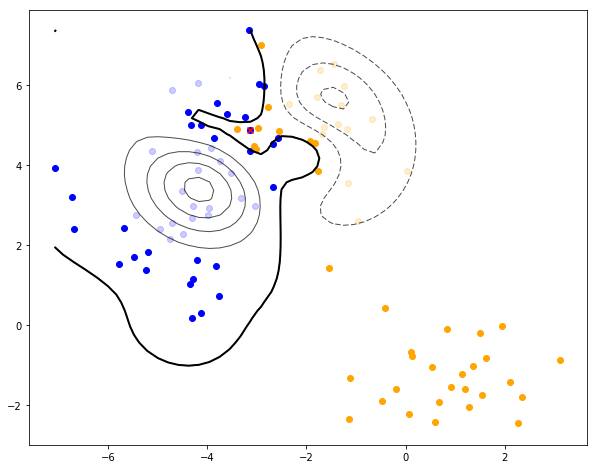

In [73]:
predicted = decision_function(samples, gaussian_kernel, support_a, support_vectors, support_labels, b)
predicted = predicted < 0
misclassified = (predicted ^ labels).astype(bool)

plt.scatter(*samples[(labels==0) & is_support].T, color='blue')
plt.scatter(*samples[(labels==1) & is_support].T, color='orange')
plt.scatter(*samples[(labels==0) & ~is_support].T, alpha=0.2, color='blue')
plt.scatter(*samples[(labels==1) & ~is_support].T, alpha=0.2, color='orange')
plt.scatter(*samples[misclassified].T, color='red', marker='x')

plt.contour(X, Y, Z, colors='k', linewidths=1, alpha=0.7)
plt.contour(X, Y, Z, [0], colors='k', linewidths=2, alpha=1.0)